In [1]:
from hifi_gan_bwe import datasets
from pathlib import Path
import torch

/home/plitsis/anaconda3/envs/bwe/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
music_dataset=datasets.MusicDataset(Path("/home/plitsis/super_res/bwe/data"), training=True)


In [3]:
music_val=datasets.MusicDataset(Path("/home/plitsis/super_res/bwe/data"), training=False)

In [8]:
music_val._seq_length

48000

In [10]:
music_val.__getitem__(0).shape

(48000,)

In [7]:
music_val.eval_set[0].shape

(12376320,)

In [6]:
vctk_dataset=datasets.VCTKDataset(Path("/home/plitsis/super_res/VCTK"), training=True)

## Test stream overlap-add

In [1]:

import argparse
from pathlib import Path

import audioread
import numpy as np
import soundfile
import torch
from tqdm import tqdm

from hifi_gan_bwe import models

/home/plitsis/anaconda3/envs/bwe/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
device="cpu"

In [3]:
audio_path="/home/plitsis/super_res/data/440_test2.wav"
model_path="/home/plitsis/super_res/hifi-gan-bwe/models/bwe-02-6fd6323-ckpt-0200k-48kHz.pt"
fade_stride=30
fade_length=0.025


In [4]:
model=models.BandwidthExtender.from_pretrained(model_path).to(device)

In [5]:
with audioread.audio_open(audio_path) as input_:
    sample_rate = input_.samplerate
    audio = (
        np.hstack([np.frombuffer(b, dtype=np.int16) for b in input_])
        .reshape([-1, input_.channels])
        .astype(np.float32)
        / 32767.0
    )

In [6]:
audio[:-1000].shape

(6479000, 1)

In [7]:
import soundfile as sf
sf.read(audio_path,dtype='float32')[0].shape

(6480000,)

In [25]:
def _stream(
    
    model: torch.nn.Module,
    x: torch.Tensor,
    sample_rate: int,
) -> torch.Tensor:
    stride_samples = int(fade_stride) * sample_rate
    fade_samples = int(fade_length * sample_rate)

    # create a linear cross-fader
    fade_in = torch.linspace(0, 1, fade_samples).to(x.device)
    fade_ou = fade_in.flip(0)
    window_size=stride_samples + fade_samples
    stride=stride_samples

    # Calculate the number of elements to pad
    # pad_size = window_size - 1 - (len(x) - window_size) % stride

    pad_size=window_size - (len(x) % (window_size-stride)) -1
    # Pad the input tensor with zeros
    padded_x = torch.cat([x, torch.zeros(pad_size, dtype=x.dtype, device=x.device)])

    # window the audio into overlapping frames
    frames = padded_x.unfold(
        dimension=0,
        size=stride_samples + fade_samples,
        step=stride_samples,
    )
    prev = torch.zeros_like(fade_ou)
    output = []
    for frame in tqdm(frames):
        # run the bandwidth extender on the current frame
        print(frame.shape)
        # y = model(frame, sample_rate)
        y=frame
        print(y.shape)
        # fade out the previous frame, fade in the current
        y[:fade_samples] = prev * fade_ou + y[:fade_samples] * fade_in
        print(y.shape)
        # save off the previous frame for fading into the next
        # and add the current frame to the output
        prev = y[-fade_samples:]
        output.append(y[:-fade_samples])

    # tack on the fade out of the last frame
    output.append(prev)
    print(torch.cat(output[:-pad_size]).shape)
    print(x.shape)
    
    return torch.cat(output[:-pad_size])


In [26]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [27]:
inputs = torch.from_numpy(audio.copy()).to(device)
x=inputs.T[0]
# x.shape
new_audio = _stream(model,x,sample_rate)

100%|██████████| 5/5 [00:00<00:00, 14084.30it/s]

torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])
torch.Size([1441200])


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/build/aten/src/ATen/RegisterCPU.cpp:21063 [kernel]
CUDA: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/build/aten/src/ATen/RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/generated/TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [9]:
x.shape

torch.Size([7200000])

In [10]:
stride_samples = int(fade_stride) * sample_rate
fade_samples = int(fade_length * sample_rate)
# inputs = torch.from_numpy(audio.copy()).to(device)
# x=inputs.T[0]
# fade_in = torch.linspace(0, 1, fade_samples).to(x.device)
# fade_ou = fade_in.flip(0)
# window_size=stride_samples + fade_samples
# stride=stride_samples
# Calculate the number of elements to pad
# pad_size = window_size - 1 - (len(x) - window_size) % stride
# pad_size=window_size - (len(x) % (window_size-stride)) -1
# Pad the input tensor with zeros
# padded_x = torch.cat([x, torch.zeros(pad_size, dtype=x.dtype)])


# window the audio into overlapping frames
frames = x.unfold(
    dimension=0,
    size=stride_samples+fade_samples,
    step=stride_samples,
)
frames2=x.split(stride_samples)


In [124]:
padded_x[:fade_samples].shape

torch.Size([1200])

In [11]:
frames.shape

torch.Size([4, 1441200])

In [128]:
len(frames[5])

1441200

In [ ]:
# a function that splits a tensor into overlapping frames

def split_overlap(x, frame_size, frame_step):
    

In [44]:
(frames[0][:1200]==torch.Tensor(audio[:1200]).squeeze(1)).all()

tensor(True)

In [37]:
torch.Tensor(audio[:stride_samples]).squeeze(1).shape

torch.Size([1440000])

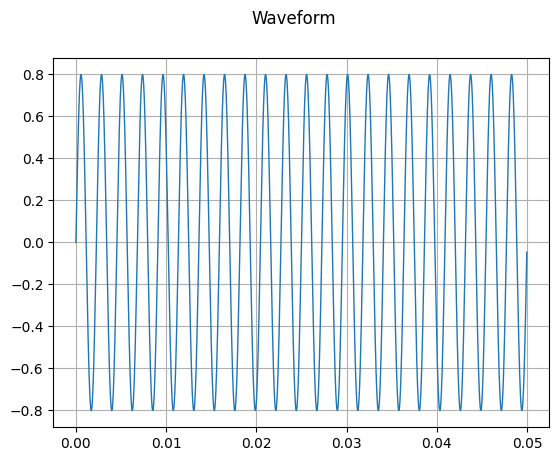

In [133]:

plot_waveform(torch.Tensor(audio[:2400]).T, sample_rate)

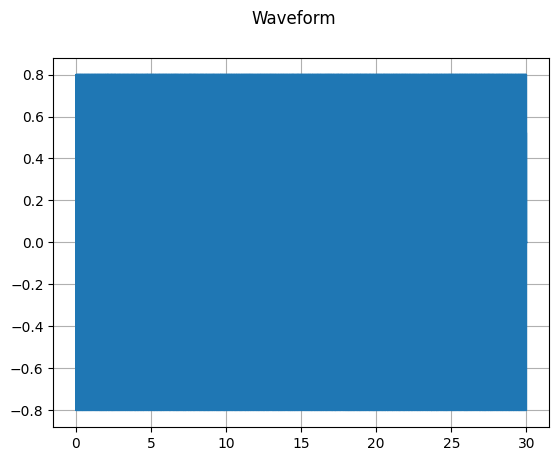

In [134]:
plot_waveform(frames[4].unsqueeze(0), sample_rate)

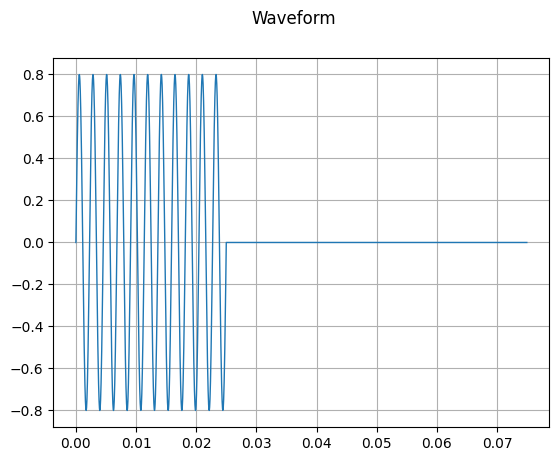

In [104]:
plot_waveform(padded_x[7200000-1200:].unsqueeze(0), sample_rate)

In [48]:
inputs = torch.from_numpy(audio.copy()).to(device)
audio_2 = (
    torch.stack([_stream(model, x, sample_rate) for x in inputs.T])
    .T.cpu()
    .numpy()
)

100%|██████████| 4/4 [00:00<00:00, 8862.77it/s]


In [49]:
audio.shape

(7200000, 1)

In [50]:
audio.shape[0]/sample_rate

150.0

In [51]:
inputs.T.shape

torch.Size([1, 7200000])

In [52]:
audio_2.shape[0]/sample_rate

120.025

In [53]:
stride_samples = int(fade_stride) * sample_rate
fade_samples = int(fade_length * sample_rate)
frames = inputs.unfold(
        dimension=0,
        size=stride_samples + fade_samples,
        step=stride_samples,
    )
fade_in = torch.linspace(0, 1, fade_samples).to(inputs.device)
fade_ou = fade_in.flip(0)
prev = torch.zeros_like(fade_ou)
output = []
for frame in tqdm(frames):
    # run the bandwidth extender on the current frame
    # y = model(frame, sample_rate)
    y=frame[0]

    # fade out the previous frame, fade in the current
    y[:fade_samples] = prev * fade_ou + y[:fade_samples] * fade_in

    # save off the previous frame for fading into the next
    # and add the current frame to the output
    prev = y[-fade_samples:]
    output.append(y[:-fade_samples])

# tack on the fade out of the last frame
output.append(prev)

100%|██████████| 4/4 [00:00<00:00, 6540.82it/s]


In [54]:
y.shape

torch.Size([1441200])

In [55]:
stride_samples

1440000

In [56]:
frames[0].shape

torch.Size([1, 1441200])

In [117]:
audio[:2400].shape

(2400, 1)

In [91]:
import torchaudio
audio2=torchaudio.load(audio_path)[0]
audio2.shape

torch.Size([1, 7200000])

In [101]:
#add one dimension to numpy array
sig = np.expand_dims(sig, axis=0)

In [106]:
sig[:,:2400]

array([[ 0.        ,  0.04608154,  0.09188843, ..., -0.13745117,
        -0.0920105 , -0.04602051]])

In [89]:
audio2[0].T[:1200].T.shape

torch.Size([1, 1200])

In [59]:
import soundfile as sf
sig, samplerate = sf.read(audio_path)

In [60]:
plot_waveform(torch.Tensor(sig[:,:2400]), sample_rate)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

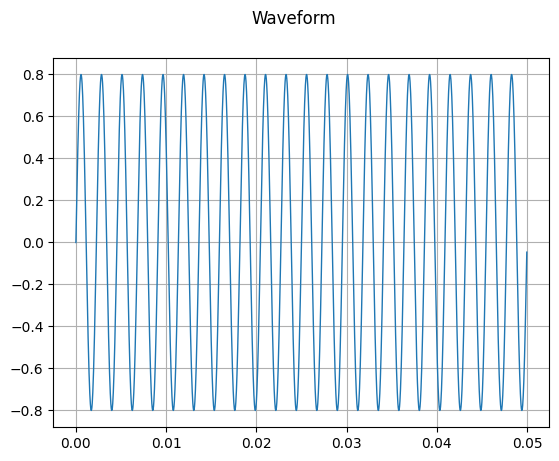

In [ ]:
plot_waveform(audio2[0].T[:2400].T, sample_rate)

In [61]:
with audioread.audio_open(audio_path) as input_:
    sample_rate = input_.samplerate
    audio = (
        np.hstack([np.frombuffer(b, dtype=np.int16) for b in input_])
        .reshape([-1, input_.channels])
        .astype(np.float32)
        / 32767.0
    )

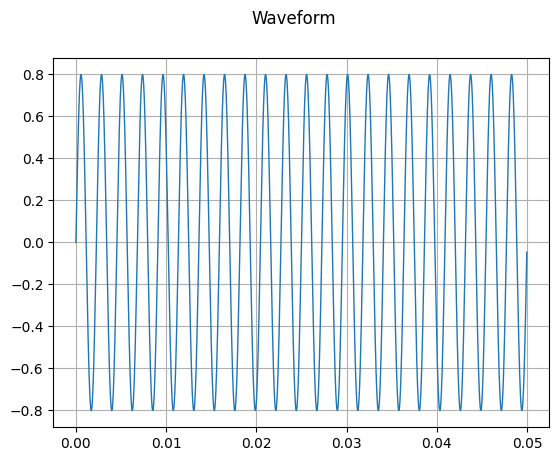

In [62]:
plot_waveform(torch.Tensor(audio[:2400]).T, sample_rate)

In [66]:
inputs = torch.from_numpy(audio.copy()).to(device)
frames = inputs.unfold(
        dimension=0,
        size=stride_samples + fade_samples,
        step=stride_samples,
    )

In [67]:
frames[0][0][:1200].unsqueeze(0).shape

torch.Size([1, 1200])

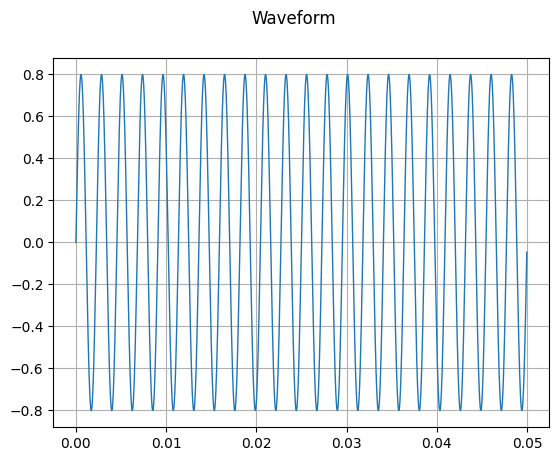

In [68]:
plot_waveform(frames[0][0][:2400].unsqueeze(0), sample_rate)

In [32]:
plot_waveform(frames[4][0][1440000:].unsqueeze(0), sample_rate)

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [ ]:
plot_waveform(frames[1].T.cpu(), sample_rate)